In [21]:
import pandas as pd
import polars as pl
import numpy as np
import lightgbm as lgb

import os
import matplotlib.pyplot as plt

In [22]:
# base_path = '/home/clas_giulia_s/buckets/b1/'
base_path = '/Users/ignacio/MAESTRIA/DMEF/'

dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
# dataset_file = 'competencia_02_fe_v01.parquet'
dataset_file = 'competencia_01_fe_modelito.csv'

ganancia_acierto = 273000
costo_estimulo = 7000

In [23]:
semillas = [5623, 292, 7494, 8504, 1663, 785, 5377, 4838, 2141, 2235, 9836, 1258, 3273, 8349, 1639, 1597, 3195, 40, 5186, 9278, 6281, 7515, 2046, 5642, 505, 4611, 3008, 2063, 2280, 1148, 618, 4806, 1503, 3926, 6363, 400, 2662, 9432, 1632, 386, 2545, 228, 1561, 3523, 4508, 9190, 8181, 7302, 6250, 7762, 8141, 6854, 622, 5327, 6379, 3867, 5420, 3030, 7275, 2040, 6042, 4365, 231, 8330, 8527, 2420, 2558, 9618, 3937, 555, 122, 4907, 7838, 5246, 100, 3243, 1449, 1052, 1906, 7657, 753, 4320, 4576, 9621, 8868, 8155, 7410, 2320, 6355, 1994, 7775, 8358, 3508, 3064, 3904, 3602, 5308, 6947, 1544, 624]

In [24]:
# data = pl.scan_csv(dataset_path + dataset_file).filter(pl.col("foto_mes") == 202104).collect()

data = pd.read_csv(dataset_path + dataset_file)
data = data[data["foto_mes"] == 202104] 

In [25]:
# # convierto a pandas dataframe
# data = data.to_pandas()

In [26]:
# Asignamos pesos a las clases

data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [27]:
data['clase_binaria'] = 0
data['clase_binaria'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)

In [28]:
X_test = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_test = data['clase_binaria']
w_test = data['clase_peso']

Cargo los modelos pre-entrenados

In [53]:
version = 'modelito_exp'

modelos_folder = modelos_path + version

modelos = [f'{modelos_folder}/{modelo}' for modelo in os.listdir(modelos_folder)]

In [54]:
len(modelos)

101

In [55]:
X_test_with_predictions = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1).copy()

In [56]:
counter = 0

for modelo in modelos[0:10]:
    
    # cargamos el modelo
    model = lgb.Booster(model_file=modelo)
    
    # predecimos para agosto
    X_test = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1).copy()
    y_pred_lgm = model.predict(X_test)
    X_test_with_predictions[f'pred_lgm_{semillas[counter]}'] = y_pred_lgm
    
    print(f'Predicciones del modelo: {modelo} DONE')
    
    counter += 1

Predicciones del modelo: /Users/ignacio/MAESTRIA/DMEF/modelos/modelito_exp/lgb_competencia1_modelito_exp_s1994.txt DONE
Predicciones del modelo: /Users/ignacio/MAESTRIA/DMEF/modelos/modelito_exp/lgb_competencia1_modelito_exp_s785.txt DONE
Predicciones del modelo: /Users/ignacio/MAESTRIA/DMEF/modelos/modelito_exp/lgb_competencia1_modelito_exp_s7275.txt DONE
Predicciones del modelo: /Users/ignacio/MAESTRIA/DMEF/modelos/modelito_exp/lgb_competencia1_modelito_exp_s6355.txt DONE
Predicciones del modelo: /Users/ignacio/MAESTRIA/DMEF/modelos/modelito_exp/lgb_competencia1_modelito_exp_s1639.txt DONE
Predicciones del modelo: /Users/ignacio/MAESTRIA/DMEF/modelos/modelito_exp/lgb_competencia1_modelito_exp_s753.txt DONE
Predicciones del modelo: /Users/ignacio/MAESTRIA/DMEF/modelos/modelito_exp/lgb_competencia1_modelito_exp_s4806.txt DONE
Predicciones del modelo: /Users/ignacio/MAESTRIA/DMEF/modelos/modelito_exp/lgb_competencia1_modelito_exp_s2046.txt DONE
Predicciones del modelo: /Users/ignacio/MA

In [57]:
X_test_with_predictions = X_test_with_predictions.copy()

In [58]:
y_pred_lgm = X_test_with_predictions.iloc[:, -10:].mean(axis=1)

ganancia = np.where(w_test == 1.00002, ganancia_acierto, 0) - np.where(w_test != 1.00002, costo_estimulo, 0)
    
idx = np.argsort(y_pred_lgm)[::-1]
ganancia = ganancia[idx]

ganancia_cum = np.cumsum(ganancia)
ganancia_max = ganancia_cum.max()
ganancia_max

np.int64(143493000)

In [59]:
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]
gan_max_idx

np.int64(10420)

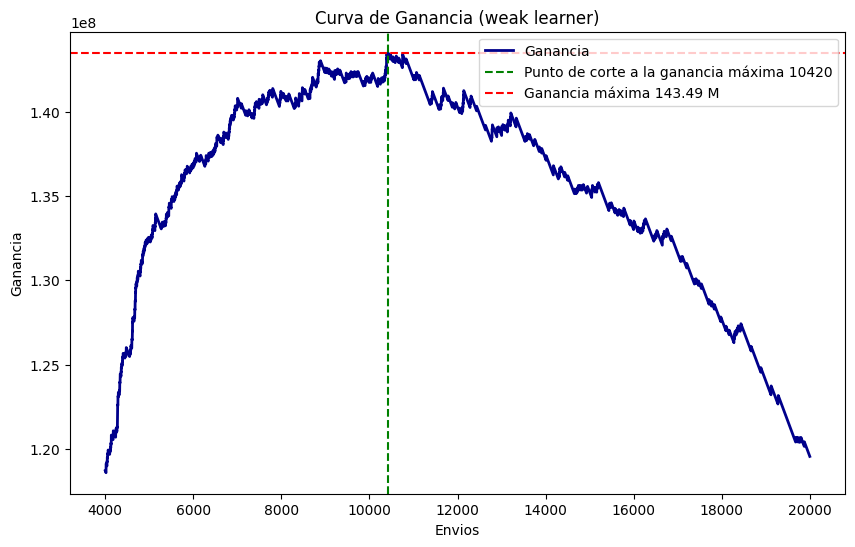

In [60]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))

plt.plot(
    range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
    ganancia_cum[piso_envios:techo_envios],
    color='darkblue',
    linewidth=2,
    label='Ganancia'
)

plt.axvline(
    x=gan_max_idx,
    color='g',
    linestyle='--',
    label=f'Punto de corte a la ganancia máxima {gan_max_idx}'
)

plt.axhline(
    y=ganancia_max,
    color='r',
    linestyle='--',
    label=f'Ganancia máxima {ganancia_max/1000000:.2f} M'
)

plt.title('Curva de Ganancia (weak learner)')
plt.xlabel('Envios')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

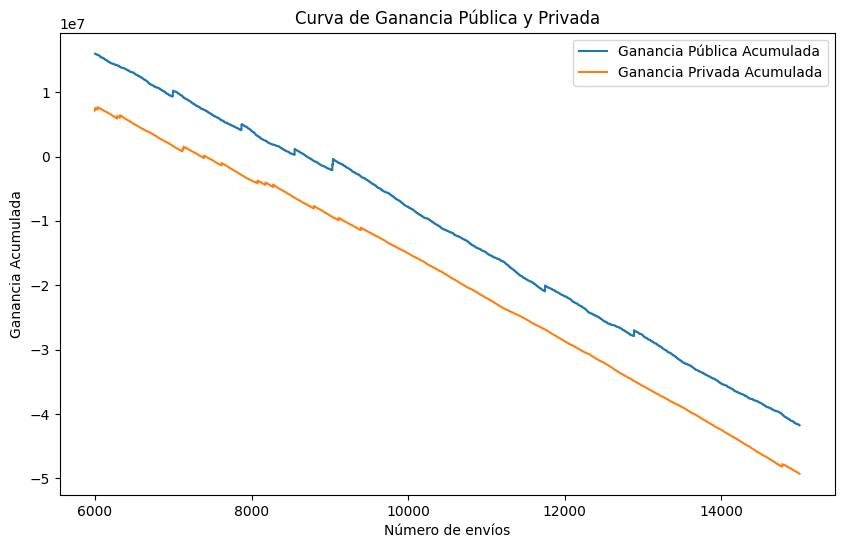

In [61]:
from sklearn.model_selection import train_test_split

df_cut_point = pd.DataFrame({'ganancia': ganancia, 'y_pred_lgm': y_pred_lgm})

private_idx, public_idx = train_test_split(X_test_with_predictions.index, test_size=0.3, random_state=42, stratify=y_test)

df_cut_point['public'] = 0.0
df_cut_point['private'] = 0.0

# Ensure private_idx contains only valid indices
valid_private_idx = [idx for idx in private_idx if idx < len(df_cut_point)]

# Perform the assignment with valid indices
df_cut_point.loc[valid_private_idx, 'private'] = ganancia[valid_private_idx] / 0.7

# Ensure public_idx contains only valid indices
valid_public_idx = [idx for idx in public_idx if idx < len(df_cut_point)]

# Perform the assignment with valid indices
df_cut_point.loc[valid_public_idx, 'public'] = ganancia[valid_public_idx] / 0.3

df_cut_point['nro_envios'] = df_cut_point.reset_index().index

df_cut_point['public_cum'] = df_cut_point['public'].cumsum()
df_cut_point['private_cum'] = df_cut_point['private'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(df_cut_point['nro_envios'][6000:15000], df_cut_point['public_cum'][6000:15000], label='Ganancia Pública Acumulada')
plt.plot(df_cut_point['nro_envios'][6000:15000], df_cut_point['private_cum'][6000:15000], label='Ganancia Privada Acumulada')

# max_public_cum = df_cut_point['public_cum'][6000:15000].max()
# max_public_idx = df_cut_point['public_cum'][6000:15000].idxmax()
# plt.axvline(x=max_public_idx, color='g', linestyle='--', label=f'Máximo Ganancia Pública en {max_public_idx}')

# max_private_cum = df_cut_point['private_cum'][6000:15000].max()
# max_private_idx = df_cut_point['private_cum'][6000:15000].idxmax()
# plt.axvline(x=max_private_idx, color='r', linestyle='--', label=f'Máximo Ganancia Privada en {max_private_idx}')

plt.title('Curva de Ganancia Pública y Privada')
plt.xlabel('Número de envíos')
plt.ylabel('Ganancia Acumulada')
plt.legend()
plt.show()

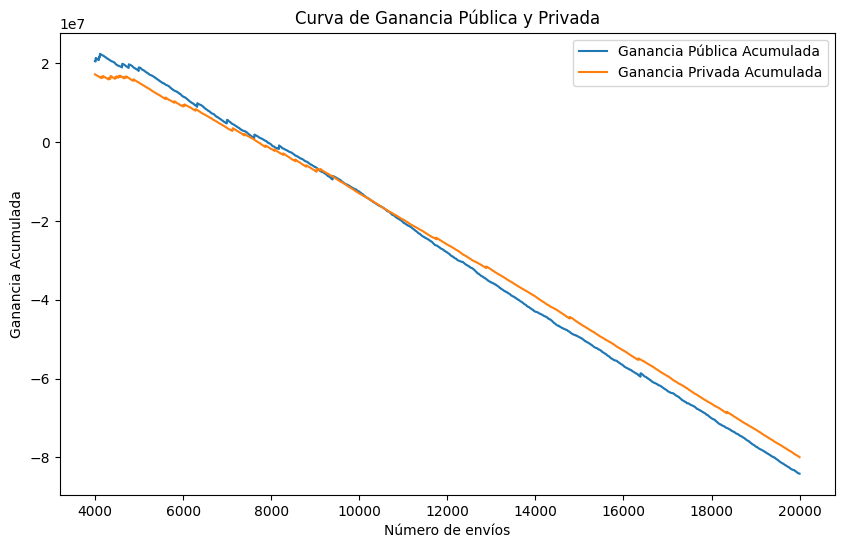

In [62]:
def analisis_1(semilla):
  df_cut_point = pd.DataFrame({'ganancia': ganancia, 'y_pred_lgm': y_pred_lgm})

  private_idx, public_idx = train_test_split(X_test_with_predictions.index, test_size=0.3, random_state=semilla, stratify=y_test)

  df_cut_point['public'] = 0.0
  df_cut_point['private'] = 0.0
  
  # Ensure private_idx contains only valid indices
  valid_private_idx = [idx for idx in private_idx if idx < len(df_cut_point)]
  df_cut_point.loc[valid_private_idx, 'private'] = ganancia[valid_private_idx] / 0.7

  # Ensure public_idx contains only valid indices
  valid_public_idx = [idx for idx in public_idx if idx < len(df_cut_point)]
  df_cut_point.loc[valid_public_idx, 'public'] = ganancia[valid_public_idx] / 0.3

  df_cut_point['nro_envios'] = df_cut_point.reset_index().index

  df_cut_point['public_cum'] = df_cut_point['public'].cumsum()
  df_cut_point['private_cum'] = df_cut_point['private'].cumsum()

  plt.figure(figsize=(10, 6))
  plt.plot(df_cut_point['nro_envios'][4000:20000], df_cut_point['public_cum'][4000:20000], label='Ganancia Pública Acumulada')
  plt.plot(df_cut_point['nro_envios'][4000:20000], df_cut_point['private_cum'][4000:20000], label='Ganancia Privada Acumulada')

  # max_public_cum = df_cut_point['public_cum'][4000:20000].max()
  # max_public_idx = df_cut_point['public_cum'][4000:20000].idxmax()
  # plt.axvline(x=max_public_idx, color='g', linestyle='--', label=f'Máximo Ganancia Pública en {max_public_idx}')

  # max_private_cum = df_cut_point['private_cum'][4000:20000].max()
  # max_private_idx = df_cut_point['private_cum'][4000:20000].idxmax()
  # plt.axvline(x=max_private_idx, color='r', linestyle='--', label=f'Máximo Ganancia Privada en {max_private_idx}')

  plt.title('Curva de Ganancia Pública y Privada')
  plt.xlabel('Número de envíos')
  plt.ylabel('Ganancia Acumulada')
  plt.legend()
  plt.show()

analisis_1(semillas[1])